# Performance optimization

In this notebook, we'll show you how to make icepack run faster if you're finding that simulation speed is becoming a barrier for you.
The solvers in icepack have been designed to give an answer as reliably as possible, even with somewhat outlandish input data.
For example, we default to solving linear systems using a direct factorization of the matrix because this approach has better guarantees of giving a useful result.
If you're willing to spend the time tweaking solver options, you can get a faster simulation using iterative linear solvers.
In this demo we'll show you how.

As a test case, we'll use the MISMIP+ experiment as describe in [Asay-Davis et al. (2016)](https://doi.org/10.5194/gmd-9-2471-2016).
MISMIP+ is a standard test problem for evaluating glaciological flow models and we'll revisit it again in the guides that follow.

In [1]:
import firedrake
from firedrake import (
    sqrt, exp, max_value, inner, as_vector, Constant, Function, dx
)

Lx, Ly = 640e3, 80e3
ny = 20
nx = int(Lx / Ly) * ny
area = Lx * Ly

mesh = firedrake.RectangleMesh(nx, ny, Lx, Ly)
Q = firedrake.FunctionSpace(mesh, "CG", 1)
V = firedrake.VectorFunctionSpace(mesh, "CG", 1)

The MISMIP+ experimental protocol defines a profile for the ice bed that is a 6th-order polynomial in $x$ and an exponential in $y$.
The bed shape was designed to create a bench or bedrock high in the $x$ direction that the ice could ground on and, given enough of a meltwater kick, to retreat off of.
The shape in the $y$ direction is designed to funnel ice off of the side walls and create geometric constrictions.

In [2]:
x, y = firedrake.SpatialCoordinate(mesh)

x_c = Constant(300e3)
X = x / x_c

B_0 = Constant(-150)
B_2 = Constant(-728.8)
B_4 = Constant(343.91)
B_6 = Constant(-50.57)
B_x = B_0 + B_2 * X**2 + B_4 * X**4 + B_6 * X**6

f_c = Constant(4e3)
d_c = Constant(500)
w_c = Constant(24e3)

B_y = d_c * (
    1 / (1 + exp(-2 * (y - Ly / 2 - w_c) / f_c)) +
    1 / (1 + exp(+2 * (y - Ly / 2 + w_c) / f_c))
)

z_deep = Constant(-720)
z_b = Function(Q).interpolate(max_value(B_x + B_y, z_deep))

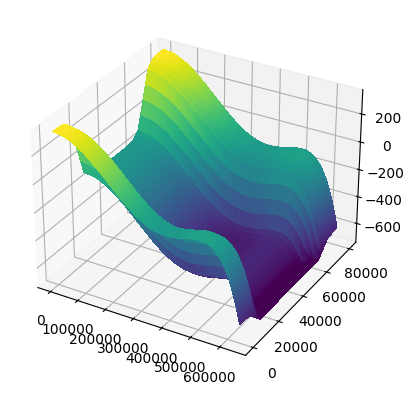

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

fig = plt.figure()
axes = fig.add_subplot(projection="3d")
firedrake.trisurf(z_b, axes=axes);

The experiment further sets the default values for the ice fluidity and friction, but leaves it to modelers to set the exact friction law.
We'll use our form of the Schoof sliding law from the tutorials on ice streams rather than the Weertman sliding law.
This sliding law crucially includes a ramping factor that smoothly dials the friction down towards the grounding line.
Without this ramping factor, the system would experience a sudden shock across the grounding line, which often manifests in numerical artifacts.

In [4]:
A = Constant(20)
C = Constant(1e-2)

In [5]:
from icepack.constants import (
    ice_density as ρ_I,
    water_density as ρ_W,
    gravity as g,
    weertman_sliding_law as m,
)

def friction(**kwargs):
    variables = ("velocity", "thickness", "surface", "friction")
    u, h, s, C = map(kwargs.get, variables)

    p_W = ρ_W * g * max_value(0, -(s - h))
    p_I = ρ_I * g * h
    N = max_value(0, p_I - p_W)
    τ_c = N / 2

    u_c = (τ_c / C)**m
    u_b = sqrt(inner(u, u))

    return τ_c * (
        (u_c**(1 / m + 1) + u_b**(1 / m + 1))**(m / (m + 1)) - u_c
    )

The experiment specifies an accumulation rate of 30 cm / year in the initial spin-up phase.
In later guides we'll look at the next phase of the experiment, which uses a pre-defined function of the depth below the water line to set sub-ice shelf melt rate.

In [6]:
a = Constant(0.3)

For now, we'll focus on the 2D ice stream model, which is more than enough to illustrate the different kinds of solver options you can choose.
Comparing the results with those of the hybrid model is a worthwhile exercise though -- it tells us the degree to which resolving vertical shear is important for the problem we're solving.

In [7]:
import icepack

model = icepack.models.IceStream(friction=friction)

### First stage

We don't have a great way to know ahead of time what the steady state of the simulation will be, so instead we'll start with a very blunt initial guess -- a constant ice thickness of 100m everywhere.
Then we'll spin this up to steady state, like we've done before for other synthetic problems.

In [8]:
h_0 = Function(Q).assign(Constant(100))
s_0 = icepack.compute_surface(thickness=h_0, bed=z_b)

Since we'll be running the same simulation several times, we'll wrap it up in a Python function.
This function will take in the solver object, the initial state of the system, the length of the simulation, and the timestep.

In [9]:
from tqdm.notebook import trange

def run_simulation(solver, h, s, u, time, dt):
    num_steps = int(final_time / dt)
    progress_bar = trange(num_steps)
    for step in progress_bar:
        h = solver.prognostic_solve(
            dt,
            thickness=h,
            velocity=u,
            accumulation=a,
            thickness_inflow=h_0,
        )
        s = icepack.compute_surface(thickness=h, bed=z_b)

        u = solver.diagnostic_solve(
            velocity=u,
            thickness=h,
            surface=s,
            fluidity=A,
            friction=C,
        )

        min_h = h.dat.data_ro.min()
        avg_h = firedrake.assemble(h * dx) / area
        description = f"avg, min h: {avg_h:4.2f}, {min_h:4.2f}"
        progress_bar.set_description(description)
        
    return h, s, u

The initial state of a constant ice thickness is very weird and unphysical.
A consequence of this is that the diagnostic equations become horribly ill-conditioned.
So to start things off we'll propagate the model forward by a few hundred years in order to get rid of some of the wilder transients.

In [10]:
dt = 3.0
final_time = 900.0

For this initial phase of the experiment, we'll use the default nonlinear solver in icepack.
This solver is slow but it's more resilient against weird input data than the alternatives.
We've shown how to pass otions to the flow solver before in order to specify which parts of the boundary have ice inflow and which parts are the side walls.
Here we're passing some extra keyword arguments: `'diagnostic_solver_type`', which can be either `'icepack'` or `'petsc'`; and `'diagnostic_solver_parameters'`, which specifies a list of options to pass to PETSc describing how to solver linear or nonlinear systems.

In [11]:
default_opts = {
    "dirichlet_ids": [1],
    "side_wall_ids": [3, 4],
    "diagnostic_solver_type": "icepack",
    "diagnostic_solver_parameters": {
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
        "tolerance": 1e-8,
    },
}
default_solver = icepack.solvers.FlowSolver(model, **default_opts)

/__w/icepack.github.io/icepack.github.io/icepack/src/icepack/solvers/flow_solver.py:152: FutureWarning: IcepackSolver will be removed in a future release, use PETScSolver
  warnings.warn(


In [12]:
u_0 = default_solver.diagnostic_solve(
    velocity=Function(V).interpolate(as_vector((90 * x / Lx, 0))),
    thickness=h_0,
    surface=s_0,
    fluidity=A,
    friction=C,
)

In [13]:
h_900, s_900, u_900 = run_simulation(
    default_solver, h_0, s_0, u_0, final_time, dt
)

  0%|          | 0/300 [00:00<?, ?it/s]

Now the interesting part begins.

### Experiment

Now that we have a more-or-less reasonable state to start from, we can experiment with solver options.
Our experiment will consist of running the model forward by 2700 years.
This still isn't quite enough to get close to steady state.
Near the shear margins, the ice thickness can get very thin -- on the order of 1-10 m -- after a few thousand years.
At the low spatial resolution we're using for this run, the solver can even get negative ice thicknesses, although this unphysical feature can be eliminated by clamping the thickness from below at every timestep.
We'll show how to increase the resolution in the demos that follow.

In [14]:
dt = 5.0
final_time = 2700

#### Baseline: icepack solver

First, let's continue using the default solver from icepack again.
We'll then try to beat this time by choosing better solvers from PETSc.

In [15]:
h, s, u = run_simulation(
    default_solver, h_900, s_900, u_900, final_time, dt
)

  0%|          | 0/540 [00:00<?, ?it/s]

And now let's visualize the results:

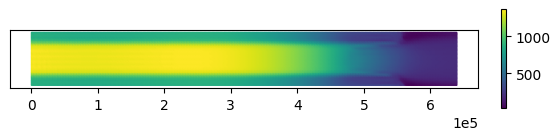

In [16]:
import icepack.plot

fig, axes = icepack.plot.subplots()
axes.get_yaxis().set_visible(False)
triangles = firedrake.tripcolor(
    h, shading="gouraud", axes=axes
)
fig.colorbar(triangles, fraction=0.01, pad=0.046);

#### PETSc with LU

Now let's try using PETSc's Scalable Nonlinear Equation Solver, or SNES.
To switch to PETSc's solver instead of icepack's, pass the key-value pair `'diagnostic_solver_type': 'petsc'` when initializing the flow solver.
You can then pass a number of parameters dictating how to solver linear and nonlinear systems.
Here, we've chosen to use a direct factorization method to solver linear systems.
This is the exact same method that the icepack solver used.
We've also specified a special type of line search -- `'cp'` for critical point.
This line search procedure assumes that the residual equations are actually the gradient of some nonlinear functional, and in our case they are -- this is exactly the action functional for the ice stream equations.
For more information, you can consult the PETSc [documentation](https://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/SNES/SNESLineSearchSetType.html).

To summarize, we're using the same algorithms with the PETSc solver as we are in the icepack solver.
This experiment is more a test of how much we save by doing all of our nonlinear equation solving with PETSc.

In [17]:
fast_opts = {
    "dirichlet_ids": [1],
    "side_wall_ids": [3, 4],
    "diagnostic_solver_type": "petsc",
    "diagnostic_solver_parameters": {
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
        "snes_line_search_type": "cp",
    },
}
fast_solver = icepack.solvers.FlowSolver(model, **fast_opts)

Using PETSc's nonlinear solvers shaved off about 1/8 of the total simulation time on the machine I'm using.
One likely explanation for some of this performance gain is that round-trips from Python to C and back are relatively expensive.
Since the icepack solver is calling out to scipy to do a line search, this round trip happens more frequently than with PETSc, which makes a single call into the C code.

In [18]:
h, s, u = run_simulation(
    fast_solver, h_900, s_900, u_900, final_time, dt
)

  0%|          | 0/540 [00:00<?, ?it/s]

#### PETSc with multigrid

Now let's see if we can do even better.
The direct solver that we used before requires the same amount of computational work no matter what.
If you already have a good guess for the solution, say by taking the value from the previous timestep, there's no way to take advantage of that information with direct solvers.
Iterative solvers, on the other hand, can converge faster with a good initial guess for the solution.
This is true of both the diagnostic equation for the ice velocity and the prognostic equation for the ice thickness.
The value of the velocity search direction from the previous Newton step or the ice thickness from the previous timestep can be a good starting guess and we should try to use this fact.

The diagnostic equations of ice flow are the derivative of a convex action functional, so the Hessian is a symmetric and positive-definite linear operator.
That means that we can use the [conjugate gradient](https://en.wikipedia.org/wiki/Conjugate_gradient_method) algorithm, which has very favorable convergence properties for symmetric and positive-definite systems.
Choosing a good preconditioner is just as important as choosing the iterative algorithm.
Here we'll be a little blunt and use PETSc's [multigrid](https://en.wikipedia.org/wiki/Multigrid_method) preconditioner.
The multigrid method can be a very efficient option for symmetric, positive elliptic systems like the linearization of the diagnostic equations.
But there may be other choices that work as well or better and, if you are concerned about performance, you should try others.
PETSc offers loads of different preconditioners; to see an exhaustive list, you can consult their [documentation](https://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/PC/index.html).

The prognostic equations don't have the nice symmetry properties of the diagnostic equations.
We'll instead use the [generalized minimum residual](https://en.wikipedia.org/wiki/Generalized_minimal_residual_method) (GMRES) algorithm together with an incomplete LU preconditioner.

In [19]:
faster_opts = {
    "dirichlet_ids": [1],
    "side_wall_ids": [3, 4],
    "diagnostic_solver_type": "petsc",
    "diagnostic_solver_parameters": {
        "ksp_type": "cg",
        "pc_type": "mg",
        "pc_mg_cycle_type": "w",
        "snes_line_search_type": "cp",
    },
    "prognostic_solver_parameters": {
        "ksp_type": "gmres",
        "pc_type": "ilu",
        "pc_factor_mat_solver_type": "petsc",
    },
}
faster_solver = icepack.solvers.FlowSolver(model, **faster_opts)

This shaves off a further 1/3 of the total simulation time.
There's a lot of room for dialing in the multigrid solver as well; for example, you can decide to use V- or W-cycles, and you can set the number of levels.
You might also be able to speed up the prognostic solver using a multigrid method, but this is likely to require more hand-tuning than for the diagnostic problem.

In [20]:
h, s, u = run_simulation(
    faster_solver, h_900, s_900, u_900, final_time, dt
)

  0%|          | 0/540 [00:00<?, ?it/s]

### Conclusion

There are a huge number of ways to accelerate nonlinear solver performance beyond what we've shown here.
PETSc implements just about anything you could dream of and then some.
To see what else is out there, you can consult the full list of [linear solvers](https://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/KSP/index.html) and [preconditioners](https://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/PC/index.html).
You can access these different solvers and preconditioners by passing the right solver parameters to the diagnostic or prognostic solver.

Making choices about solution methods is often a tradeoff between robustness and speed.
For this simulation, we had to use the more robust but slower solver in icepack for the first 900 years of the spin-up because the equivalent line search solvers in PETSc would fail.
(They would actually work fine on some machines but fail on others, because computing is hard.)
The trust region method from PETSc does work for the first 900 simulation years as well, but can be slower on more reasonable inputs.
If you are interested in tuning performance, **you should expect to use multiple solution methods in the same simulation**, especially if the system can meander through multiple regimes.

We've focused here on how to get the most performance out of a single simulation at a fixed resolution.
Things get much more interesting when we need to get an accurate result and are free to increase the resolution as need be.
For these types of problems, a lot of the work can be done at coarser resolution and knowing exactly how much is both an art and a science.